In [1]:
import covidtransform as cvdt
import numpy as np
import matplotlib.pyplot as plt

In [15]:
df = cvdt.load_and_clean(nama_file='time_series_covid19_confirmed_global.csv',region_filter='indonesia', type_of_covid='confirmed')
df

,Province/State,Country/Region,Lat,Long,date,confirmed count
149,NaN,Indonesia,-0.7893,113.9213,2020-01-22,0
438,NaN,Indonesia,-0.7893,113.9213,2020-01-23,0
727,NaN,Indonesia,-0.7893,113.9213,2020-01-24,0
1016,NaN,Indonesia,-0.7893,113.9213,2020-01-25,0
1305,NaN,Indonesia,-0.7893,113.9213,2020-01-26,0
...,...,...,...,...,...,...
329031,NaN,Indonesia,-0.7893,113.9213,2023-03-05,6737159
329320,NaN,Indonesia,-0.7893,113.9213,2023-03-06,6737303
329609,NaN,Indonesia,-0.7893,113.9213,2023-03-07,6737606
329898,NaN,Indonesia,-0.7893,113.9213,2023-03-08,6737918


In [16]:
df = cvdt.getconfirmed(df)
df

,date,confirmed count
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
1138,2023-03-05,6737159
1139,2023-03-06,6737303
1140,2023-03-07,6737606
1141,2023-03-08,6737918


In [17]:
df = cvdt.new_case_per_day(df) # Kasus baru perhari

gamma = float(1/7) # Menentukan gamma
df = cvdt.infected_per_day(df,gamma) # Estimasi jumlah Infected perhari 
df = cvdt.growth(df) # Pertumbuhan kasus Infected
df = cvdt.rrate(df,gamma) # Menghitung Laju Reproduksi
df = cvdt.sum_confirmed(df,100)
df

,date,confirmed count,New_Cases_per_day,I_t,gr,R_k
0,2020-03-16,134,17,88.95,0.059685,1.417798
1,2020-03-17,172,38,114.24,0.284317,2.990219
2,2020-03-18,227,55,152.92,0.338585,3.370098
3,2020-03-19,311,84,215.08,0.406487,3.845409
4,2020-03-20,369,58,242.35,0.126790,1.887530
...,...,...,...,...,...,...
1084,2023-03-05,6737159,165,1474.11,-0.034826,0.756217
1085,2023-03-06,6737303,144,1407.52,-0.045173,0.683789
1086,2023-03-07,6737606,303,1509.45,0.072418,1.506927
1087,2023-03-08,6737918,312,1605.81,0.063838,1.446865


### Plot data estimasi reproduction rate

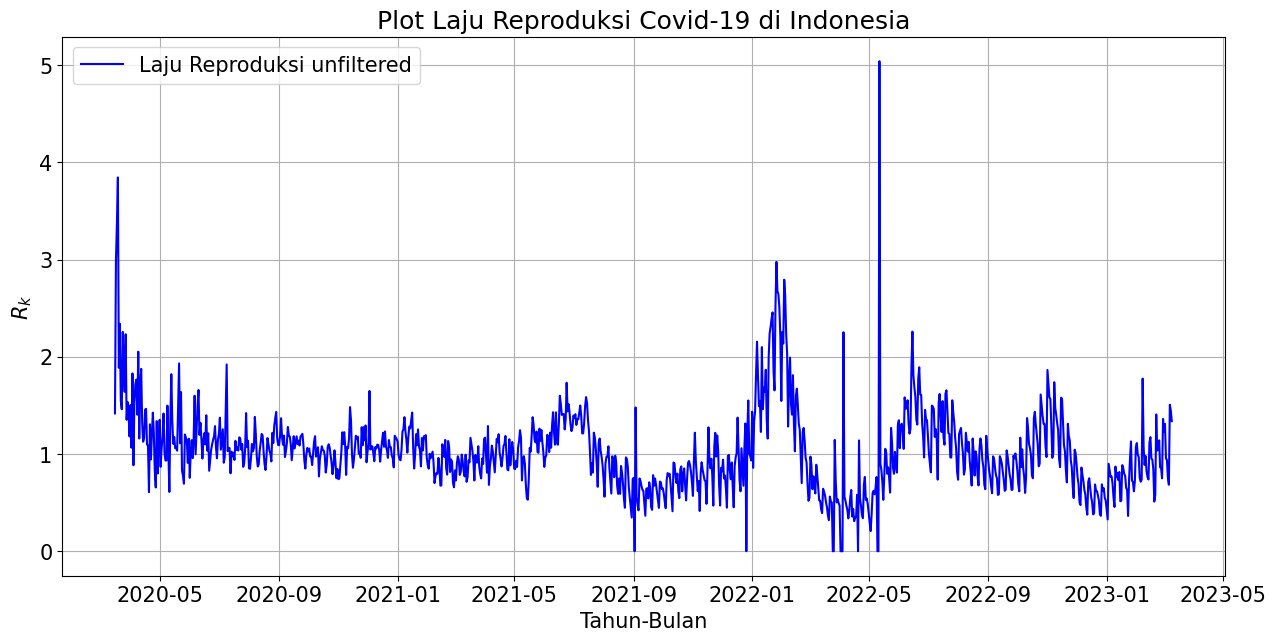

In [18]:
plt.figure(figsize=(15, 7))
plt.rcParams['font.size'] = "15"
plt.xlabel('Tahun-Bulan', fontsize = "15")
plt.ylabel(r"$R_k$", fontsize = "15")
plt.title('Plot Laju Reproduksi Covid-19 di Indonesia')
plt.plot(df['date'], df['R_k'], 'b-', label='Laju Reproduksi unfiltered')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
A = 1
B = 1
u = 0
H = 1
Pp = 1
Q = 5
R = 700
df.loc[0,'xhat_p'] = df.loc[0, 'R_k'] + np.random.normal(0, np.sqrt(Pp))
df.loc[0,'Pp'] = Pp

# smoothing pada data covid dengan data-driven KF 
for i, row in df.iterrows():
    if i == df.index[-1]:
        continue
    else:
        df.at[i+1, 'xhat_n'] = A * df.at[i, 'xhat_p'] + B*u # persamaan KF-1
        df.at[i+1, 'Pn'] = A * df.at[i, 'Pp'] *A + Q # persamaan KF-2
        df.at[i+1, 'K'] = df.at[i+1, 'Pn'] * H / (H * df.at[i+1, 'Pn'] * H + R) # persamaan KF-3
        df.at[i+1, 'xhat_p'] = df.at[i+1, 'xhat_n'] + df.at[i+1, 'K']*(df.at[i+1, 'R_k'] - (H * df.at[i+1, 'xhat_n'])) # persamaan KF-4
        df.at[i+1, 'Pp'] = 1/(1/(df.at[i+1, 'Pn']) + H * (1/R) * H) # persamaan KF-5

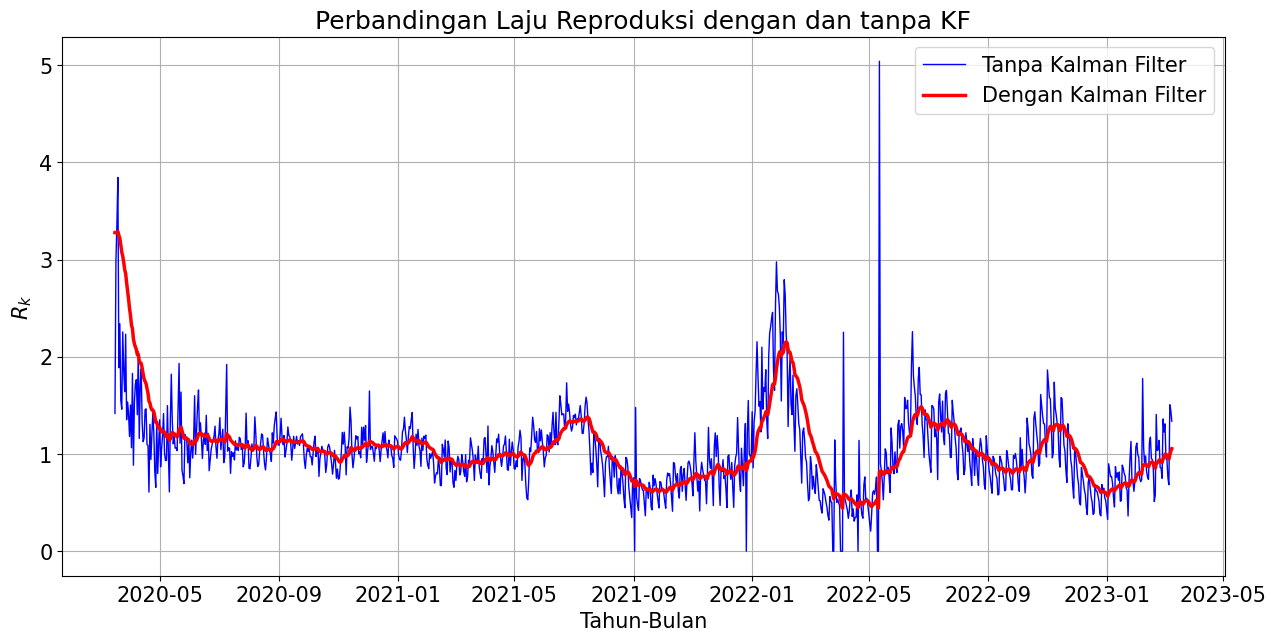

In [25]:
plt.figure(figsize=(15, 7))
plt.rcParams['font.size'] = "15"
plt.xlabel('Tahun-Bulan', fontsize = "15")
plt.ylabel(r"$R_k$", fontsize = "15")
plt.title('Perbandingan Laju Reproduksi dengan dan tanpa KF')


plt.plot(df['date'], df['R_k'], 'b-', label='Tanpa Kalman Filter', linewidth = '1')
plt.plot(df['date'], df['xhat_p'], 'r', label='Dengan Kalman Filter', linewidth = "2.5")#, linestyle='dashed')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
df

,date,confirmed count,New_Cases_per_day,I_t,gr,R_k,xhat_p,Pp,xhat_n,Pn,K
0,2020-03-16,134,17,88.95,0.059685,1.417798,3.277882,1.000000,NaN,NaN,NaN
1,2020-03-17,172,38,114.24,0.284317,2.990219,3.275437,5.949008,3.277882,6.000000,0.008499
2,2020-03-18,227,55,152.92,0.338585,3.370098,3.276895,10.780388,3.275437,10.949008,0.015401
3,2020-03-19,311,84,215.08,0.406487,3.845409,3.289429,15.432487,3.276895,15.780388,0.022046
4,2020-03-20,369,58,242.35,0.126790,1.887530,3.249669,19.852993,3.289429,20.432487,0.028361
...,...,...,...,...,...,...,...,...,...,...,...
1084,2023-03-05,6737159,165,1474.11,-0.034826,0.756217,0.971391,56.713596,0.990362,61.713596,0.081019
1085,2023-03-06,6737303,144,1407.52,-0.045173,0.683789,0.948090,56.713596,0.971391,61.713596,0.081019
1086,2023-03-07,6737606,303,1509.45,0.072418,1.506927,0.993367,56.713596,0.948090,61.713596,0.081019
1087,2023-03-08,6737918,312,1605.81,0.063838,1.446865,1.030109,56.713596,0.993367,61.713596,0.081019
